# Defining the autoencoder

Now, let's define an autoencoder to learn to reconstruct the training data after compressing it through a bottleneck, then decompressing it again.

<img src="images/ae.png" alt="The autoencoder" width="800" img align="center"/>

For that, we need a stack of dense layers:

# Let's train!

The reconstructed $p_T$ has an unphysical tail below zero. For a real usecase, we would force the output to be positive for that column, as well as treat the zero-padded cases differently in the loss.
To keep it short, we won't do that now, but you can read more about it [here](https://arxiv.org/abs/2108.03986)

We then need to compute the mean-square-error, which will be our final discriminating variable. This you would need to write custom if applying the changes we mention above:

## PyTorch Implementation

### Get (pre-processed) data


In [2]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
DATA_PATH = "../data/"

with h5py.File(DATA_PATH + 'bkg_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    
with h5py.File(DATA_PATH + 'signal_dataset.h5', 'r') as file:
    signal_test_data = np.array(file['Data'])

In [3]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 32),                     # Equivalent to Dense(32)
            nn.BatchNorm1d(32),                             # BatchNormalization
            nn.LeakyReLU(0.3),                              # LeakyReLU activation

            nn.Linear(32, 16),                              # Dense(16)
            nn.BatchNorm1d(16),                             # BatchNormalization
            nn.LeakyReLU(0.3),                              # LeakyReLU activation

            nn.Linear(16, latent_dim)                       # Compress to latent space
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),                      # Start decoding from latent space
            nn.BatchNorm1d(16),                             # BatchNormalization
            nn.LeakyReLU(0.3),                              # LeakyReLU activation

            nn.Linear(16, 32),                              # Dense(32)
            nn.BatchNorm1d(32),                             # BatchNormalization
            nn.LeakyReLU(0.3),                              # LeakyReLU activation

            nn.Linear(32, input_shape)                      # Reconstruct input shape
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



# Summary (Optional, requires the torchsummary package)
#from torchsummary import summary
#summary(autoencoder, input_size=(input_shape,))


In [5]:
# Model parameters
input_shape = X_train.shape[1]
latent_dim = 3

# Create the autoencoder model
autoencoder = Autoencoder(input_shape=input_shape, latent_dim=latent_dim)
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=42, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.3)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.3)
    (6): Linear(in_features=16, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.3)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.3)
    (6): Linear(in_features=32, out_features=42, bias=True)
  )
)


In [6]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

# Check if CUDA is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
autoencoder = Autoencoder(input_shape=input_shape, latent_dim=latent_dim).to(device)

# Loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-5)

# Callbacks equivalent
class EarlyStopping:
    def __init__(self, patience=10, delta=0, restore_best_weights=True):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta
        self.restore_best_weights = restore_best_weights
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_weights = model.state_dict()
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model_weights)
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_weights = model.state_dict()

# ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, min_lr=1e-6)

# Training parameters
EPOCHS = 5
BATCH_SIZE = 1024
train = True

# Early Stopping Callback
early_stopping = EarlyStopping(patience=10, delta=1e-4, restore_best_weights=True)

# Training loop
if train:
    train_data = torch.tensor(X_train, dtype=torch.float32).to(device)
    val_split = int(0.8 * len(train_data))
    train_set, val_set = torch.utils.data.random_split(train_data, [val_split, len(train_data) - val_split])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

    for epoch in range(EPOCHS):
        autoencoder.train()
        train_loss = 0
        for batch in train_loader:
            inputs = batch.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = autoencoder(inputs)

            # Calculate loss
            loss = criterion(outputs, inputs)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation loop
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch.to(device)
                outputs = autoencoder(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item()

        # ReduceLROnPlateau and EarlyStopping callbacks
        scheduler.step(val_loss / len(val_loader))
        early_stopping(val_loss / len(val_loader), autoencoder)

        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss/len(train_loader):.6f}, Val Loss: {val_loss/len(val_loader):.6f}")

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Save the model
    torch.save(autoencoder.state_dict(), 'baseline_ae.pth')
else:
    # Load the model
    autoencoder.load_state_dict(torch.load('baseline_ae.pth'))

# Inference
autoencoder.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
signal_test_tensor = torch.tensor(signal_test_data, dtype=torch.float32).to(device)

with torch.no_grad():
    bkg_prediction = autoencoder(X_test_tensor).cpu().numpy()
    signal_prediction = autoencoder(signal_test_tensor).cpu().numpy()


/mnt/d/codigos/posdoc/CMS-ML-analysis/.cmsml/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 1.102290, Val Loss: 0.970920
Epoch 2/5, Train Loss: 0.985640, Val Loss: 0.884846
Epoch 3/5, Train Loss: 0.921881, Val Loss: 0.835462
Epoch 4/5, Train Loss: 0.883846, Val Loss: 0.804947
Epoch 5/5, Train Loss: 0.859913, Val Loss: 0.788153


In [7]:
X_test_tensor.shape

torch.Size([434800, 42])

In [8]:
bkg_prediction.shape

(434800, 42)

In [ ]:
import torch
import torch.nn as nn

def create_autoencoder(input_dim, latent_dim, encoder_layers, decoder_layers, activation_fn=nn.LeakyReLU, dropout_rate=0.0):
    """
    Cria um autoencoder com base em parâmetros fornecidos.
    
    :param input_dim: Dimensão da entrada (número de características).
    :param latent_dim: Dimensão do espaço latente.
    :param encoder_layers: Lista com o número de neurônios para cada camada do encoder.
    :param decoder_layers: Lista com o número de neurônios para cada camada do decoder.
    :param activation_fn: Função de ativação a ser usada (padrão: LeakyReLU).
    :param dropout_rate: Taxa de dropout a ser aplicada (padrão: 0, ou seja, sem dropout).
    
    :return: Um modelo de autoencoder construído dinamicamente.
    """
    class DynamicAutoencoder(nn.Module):
        def __init__(self):
            super(DynamicAutoencoder, self).__init__()
            
            # Criação dinâmica do encoder
            encoder = []
            in_dim = input_dim
            for layer_size in encoder_layers:
                encoder.append(nn.Linear(in_dim, layer_size))
                encoder.append(nn.BatchNorm1d(layer_size))
                encoder.append(activation_fn(0.3))  # Padrão: LeakyReLU com alpha 0.3
                if dropout_rate > 0:
                    encoder.append(nn.Dropout(dropout_rate))  # Adiciona dropout se especificado
                in_dim = layer_size
            
            encoder.append(nn.Linear(in_dim, latent_dim))  # Camada latente
            self.encoder = nn.Sequential(*encoder)
            
            # Criação dinâmica do decoder
            decoder = []
            in_dim = latent_dim
            for layer_size in decoder_layers:
                decoder.append(nn.Linear(in_dim, layer_size))
                decoder.append(nn.BatchNorm1d(layer_size))
                decoder.append(activation_fn(0.3))
                if dropout_rate > 0:
                    decoder.append(nn.Dropout(dropout_rate))
                in_dim = layer_size
            
            decoder.append(nn.Linear(in_dim, input_dim))  # Reconstrução da entrada
            self.decoder = nn.Sequential(*decoder)
        
        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded
    
    return DynamicAutoencoder()

# Exemplo de uso:
input_dim = 100  # Exemplo: 100 características de entrada
latent_dim = 10  # Tamanho do espaço latente
encoder_layers = [64, 32]  # Tamanhos das camadas do encoder
decoder_layers = [32, 64]  # Tamanhos das camadas do decoder
dropout_rate = 0.2  # Adicionar dropout com taxa de 20%

autoencoder = create_autoencoder(input_dim, latent_dim, encoder_layers, decoder_layers, activation_fn=nn.ReLU, dropout_rate=dropout_rate)
print(autoencoder)


## Evaluate the models


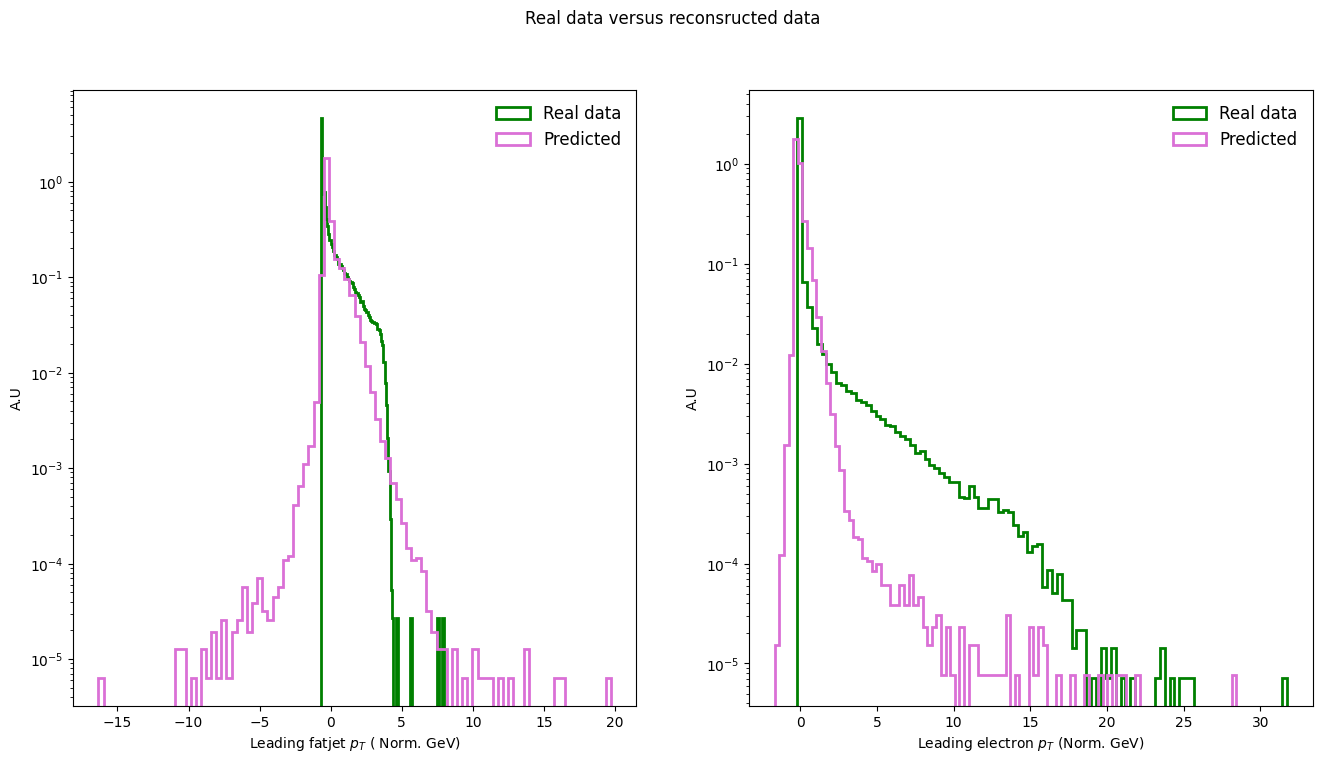

In [9]:
fig, axs = plt.subplots(1,2,figsize=(16,8))
fig.suptitle('Real data versus reconsructed data')
axs[0].hist(X_test[:,0],bins=100,label=r'Real data',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[0].hist(bkg_prediction[:,0],bins=100,label=r'Predicted',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[0].semilogy()
axs[0].set(xlabel=u'Leading fatjet $p_{T}$ ( Norm. GeV)', ylabel='A.U')
axs[0].legend(loc='best',frameon=False, ncol=1,fontsize='large')

axs[1].hist(X_test[:,18],bins=100,label=r'Real data',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[1].hist(bkg_prediction[:,18],bins=100,label=r'Predicted',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[1].set(xlabel=u'Leading electron $p_{T}$ (Norm. GeV)', ylabel='A.U')
axs[1].semilogy()
axs[1].legend(loc='best',frameon=False, ncol=1,fontsize='large')

In [14]:
import torch
import torch.nn.functional as F

# Certifique-se de que as entradas são tensores PyTorch
X_test = torch.tensor(X_test).float()  # Converte de NumPy para tensor PyTorch (se necessário)
bkg_prediction = torch.tensor(bkg_prediction).float()  # Converte de NumPy para tensor PyTorch
signal_test_data = torch.tensor(signal_test_data).float()  # Converte de NumPy para tensor PyTorch
signal_prediction = torch.tensor(signal_prediction).float()  # Converte de NumPy para tensor PyTorch

# Define a função de perda MSE
def mse_loss(true, prediction):
    loss = torch.mean((true - prediction) ** 2, dim=-1)
    return loss

# Calcular o MSE entre os dados de teste e as predições
mse_sm = mse_loss(X_test, bkg_prediction).detach().numpy()
mse_bsm = mse_loss(signal_test_data, signal_prediction).detach().numpy()

# Agora `mse_sm` e `mse_bsm` contêm os valores de perda em formato NumPy


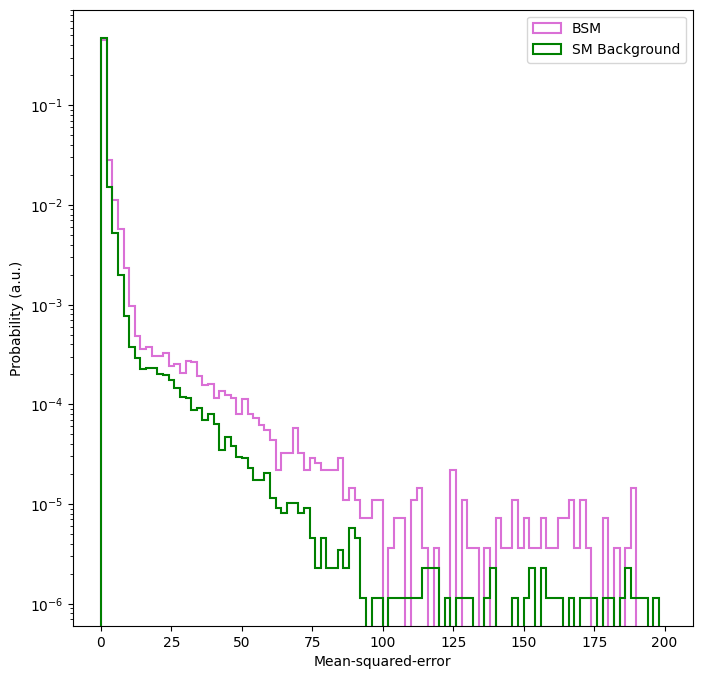

In [15]:
bin_size=100

plt.figure(figsize=(8,8))
n, bins, patches =plt.hist(mse_bsm, bins=bin_size, label="BSM", density = True, histtype='step', fill=False, edgecolor='orchid', linewidth=1.5,range=[0,200])
n_, bins_, patches_ =plt.hist(mse_sm, bins=bin_size, label="SM Background", density = True, histtype='step', fill=False, edgecolor='green', linewidth=1.5,range=[0,200])
plt.yscale('log')
plt.xlabel("Mean-squared-error")
plt.ylabel("Probability (a.u.)")
plt.legend(loc='best')
plt.show()

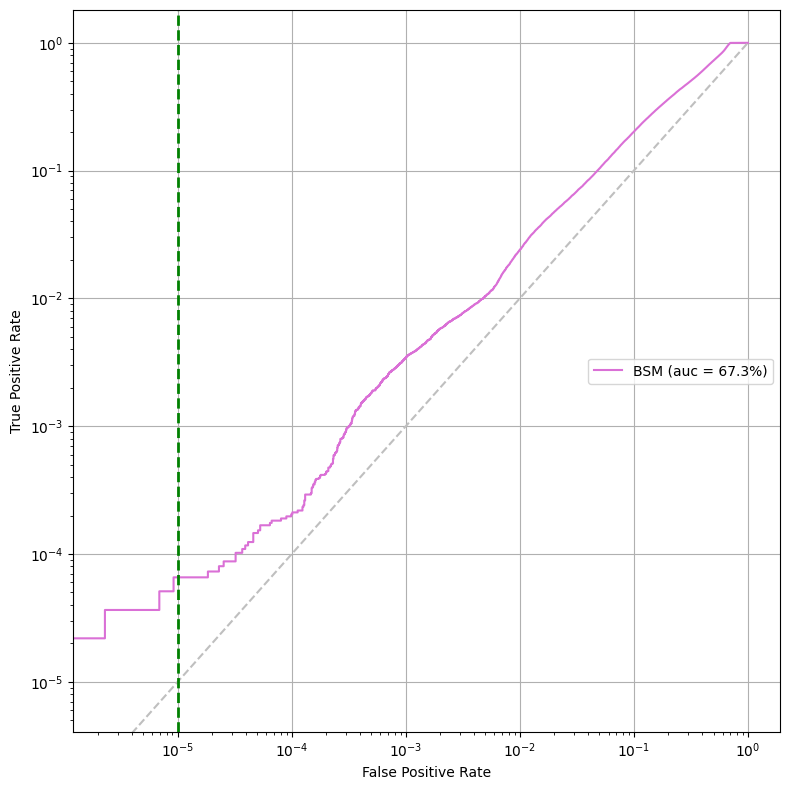

In [16]:
from sklearn.metrics import roc_curve, auc

target_background = np.zeros(mse_sm.shape[0])

plt.figure(figsize=(8,8))
trueVal = np.concatenate((np.ones(mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((mse_bsm, mse_sm))

fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

auc_loss = auc(fpr_loss, tpr_loss)
    
plt.plot(fpr_loss, tpr_loss, "-", label='BSM (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
     
plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='green', linestyle='dashed', linewidth=2) # threshold value for measuring anomaly detection efficiency
plt.show()

A função apresentada utiliza a **curva ROC (Receiver Operating Characteristic)** e a **AUC (Área sob a Curva ROC)** para avaliar o desempenho do autoencoder na detecção de anomalias (anomalies) versus dados de fundo (background). Aqui está uma explicação detalhada do que cada parte da função faz e o que os resultados representam:

### 1. **Importações e Inicializações:**
```python
from sklearn.metrics import roc_curve, auc
```
Aqui, você importa duas funções:
- `roc_curve`: Para calcular a curva ROC.
- `auc`: Para calcular a área sob a curva ROC (AUC), que é uma métrica comum para medir o desempenho de classificadores binários.

```python
target_background = np.zeros(mse_sm.shape[0])
```
Aqui, você está criando um array `target_background` de zeros, que tem o mesmo comprimento que `mse_sm` (Mean Squared Error para os dados de fundo). Isso indica que as amostras de fundo (background) são rotuladas como **0**.

### 2. **Preparação dos Dados Verdadeiros (Labels) e Predições (Scores):**
```python
trueVal = np.concatenate((np.ones(mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((mse_bsm, mse_sm))
```
- **`trueVal`:** Um array que combina `np.ones(mse_bsm.shape[0])` (rótulos `1` para anomalias) com `target_background` (rótulos `0` para o fundo). Isso cria uma lista de rótulos reais, onde **1 representa anomalias (BSM - Beyond Standard Model)** e **0 representa o background**.
- **`predVal_loss`:** Um array que combina os valores de erro de reconstrução (`mse_bsm` para os dados de anomalias e `mse_sm` para os dados de fundo). Esses valores de MSE são usados como predições do modelo, onde **valores mais altos de MSE indicam maior probabilidade de serem anomalias**.

### 3. **Cálculo da Curva ROC e AUC:**
```python
fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
auc_loss = auc(fpr_loss, tpr_loss)
```
- **`roc_curve`:** Esta função calcula a curva ROC, que é uma representação gráfica da relação entre o **True Positive Rate (TPR)** e o **False Positive Rate (FPR)** para diferentes valores de threshold.
  - `fpr_loss`: Taxa de falsos positivos (False Positive Rate) para diferentes limiares (thresholds).
  - `tpr_loss`: Taxa de verdadeiros positivos (True Positive Rate) para diferentes limiares.
  - `threshold_loss`: Os thresholds usados para calcular `fpr_loss` e `tpr_loss`.

- **`auc_loss`:** A área sob a curva ROC (AUC) é calculada. O valor da AUC indica o quão bem o modelo é capaz de separar as anomalias dos dados de fundo.
  - A AUC varia de 0 a 1, onde:
    - **1.0** indica uma separação perfeita entre classes (anomalias e background).
    - **0.5** indica uma separação aleatória (o modelo não está distinguindo bem).

### 4. **Visualização Gráfica da Curva ROC:**
```python
plt.plot(fpr_loss, tpr_loss, "-", label='BSM (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
```
- A curva ROC é plotada, mostrando a relação entre o TPR e o FPR.
- O rótulo inclui a AUC, multiplicada por 100 para ser exibida como uma porcentagem.

```python
plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='green', linestyle='dashed', linewidth=2) # threshold value for measuring anomaly detection efficiency
plt.show()
```
- **Eixos logarítmicos:** Os eixos X (FPR) e Y (TPR) são colocados em escala logarítmica para destacar a performance em regiões de baixos valores de FPR.
- **Linha verde vertical:** Representa um limiar fixo (`0.00001`), onde você pode medir a eficiência do modelo em detectar anomalias com baixa taxa de falsos positivos.
- **Curva de referência:** A linha pontilhada representa a linha de "chance" (caso o modelo estivesse simplesmente fazendo escolhas aleatórias, TPR = FPR).

### O que o Gráfico Significa:
- **True Positive Rate (TPR) ou Sensibilidade:** Indica a fração de anomalias corretamente detectadas.
- **False Positive Rate (FPR):** Indica a fração de dados de fundo incorretamente classificados como anomalias.
- **AUC (Area Under the Curve):** Mede a capacidade do modelo de distinguir entre as classes (anomalias e fundo). Quanto mais perto de 1, melhor o desempenho do modelo. Uma AUC de 0.5 indica que o modelo não está fazendo uma distinção útil.
  
No gráfico resultante:
- **Curvas mais próximas do canto superior esquerdo (TPR alto e FPR baixo)** indicam um bom desempenho na detecção de anomalias com poucos falsos positivos.
- A linha verde vertical no gráfico indica o threshold escolhido para avaliar a eficiência do modelo a partir de um determinado ponto de corte na FPR.

### Resumo:
Essa função está demonstrando a **eficácia do autoencoder** em detectar anomalias, visualizando a relação entre a **taxa de verdadeiros positivos (TPR)** e a **taxa de falsos positivos (FPR)** para diferentes thresholds. O objetivo é maximizar o TPR enquanto minimiza o FPR, o que indica um bom desempenho na separação de anomalias e dados de fundo.

---
Hint, if you want to include MET or HT they won't become "objects" like the electron/muon/jets. You could also not "zip" when loading, and then do the zip'ing manually:
```
# Lets convert to correct formatting ao that all objects are zipped together as Momentum4D vectors
new_arr_sig = {}
for obj, brs in branch_dict.items():
    new_arr_sig[obj] = ak.zip({ br : data_sig[obj + "_" + br] for br in brs} )
      
  
# making sure it is a Momentum4D object like the rest
final_arr_sig = {}
for key, value in new_arr_sig.items(): final_arr_sig[key] = ak.Array( value, with_name = "Momentum4D" )

len(ak.Array(final_arr_sig))

new_arr_bkg = {}
for obj, brs in branch_dict.items():
    new_arr_bkg[obj] = ak.zip({ br : data_bkg[obj + "_" + br] for br in brs} )
      
  
# making sure it is a Momentum4D object like the rest
final_arr_bkg = {}
for key, value in new_arr_bkg.items(): final_arr_bkg[key] = ak.Array( value, with_name = "Momentum4D" )

len(ak.Array(final_arr_sig))

data_sig = ak.Array(final_arr_sig)
data_bkg = ak.Array(final_arr_bkg)
